<a href="https://colab.research.google.com/github/dric2018/ZindiTuberculosisClassification/blob/main/TB0-final-torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Tue Nov 17 22:24:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloads

# Imports

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

import random

import albumentations as al 

from PIL import Image
import cv2
import sklearn
from sklearn.metrics import roc_curve, auc, log_loss, precision_score, f1_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib as mplb 
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd 

from tensorflow.keras.utils import to_categorical
import os 
import zipfile
import shutil
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings(action='ignore')

#Keras 
from keras.utils import to_categorical



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Config

In [19]:
class_names = ['NEG', 'POS']
data_dir = '/content/drive/MyDrive/ZindiTuberculosisChallenge/data' # change to the path to .zip files (zip files must be in a folder named Zip to be exctracted by the above code)
                                                                    # or just use the unzip bash command to extract files into /data/Zip/Images
base_dir = '/content'

# create dirs 
PATHS = {
    'cwd': '/content/', #Current directory
    'arch': '/content/MODELS/', #Folder in which we're going to save our models
    'raw': '/content/data/Csv/', #Folder containing the training files
    'images': '/content/data/Zip/Images/train/', #this folder is going to store our images files
    'test_images' : '/content/data/Zip/Images/test/'
    }

os.makedirs(PATHS['arch'], exist_ok=True)


seed_val = 2020 # for reproductibility
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
# extract files
files_base_path = data_dir + '/Zip'

def extract_files(task='train', dest = '/content/data/Zip/Images'):
  src = f"{files_base_path}/{task}"
  dest = os.path.join(dest, f'{task}')
  try:
      with zipfile.ZipFile(f"{src}.zip", 'r') as zip_ref:
          # Loop over each file
          for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist()), desc="Extrating files"):

              # Extract each file to another directory
              # If you want to extract to current working directory, don't specify path
              zip_ref.extract(member=file, path=dest)
          # print('[INFO] Done !')
      
  except Exception as ex:
      print(f'[ERROR] {ex}')


In [23]:
extract_files(task='train')
extract_files(task='test')

In [25]:
# # move uploaded files 
try:
  files_to_move = ['Test.csv', 'Train.csv', 'SampleSubmission.csv'] 
  for f in files_to_move:
    shutil.copy(src = os.path.join(data_dir, 'Csv' , f), dst=os.path.join(base_dir, 'data/Csv', f))
except:
  os.makedirs('/content/data/Csv')
  files_to_move = ['Test.csv', 'Train.csv', 'SampleSubmission.csv'] 
  for f in files_to_move:
    shutil.copy(src = os.path.join(data_dir, f), dst=os.path.join(base_dir, 'data/Csv', f))

# Classes

In [26]:
class TBDataset(torch.utils.data.Dataset):
    def __init__(self, df, task='train', size=(300, 230), use_tfms=True, **kwargs):
        super(TBDataset, self).__init__()
        self.df = df
        self.task = task
        self.size = size
        self.use_tfms = use_tfms
        self.c = 2

        self.train_transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),

        ])
        self.test_transforms = transforms.Compose([
          transforms.ToTensor(),
        ])


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.task == 'train':

          fn = self.df.loc[idx, 'filename']
          img = cv2.imread(os.path.join(PATHS['images'], fn))
          img = cv2.resize(img, self.size)


        else:
          fn = self.df.loc[idx, 'filepath']
          img = cv2.imread(os.path.join(PATHS['test_images'], fn))
          img = cv2.resize(img, self.size)

        if self.use_tfms: 
          img = self.train_transforms(img)

        else:
          img = self.test_transforms(img)

        output = {
              'image': img,
          }

        if self.task == 'train':
            label = self.df.loc[idx, 'LABEL']
            output.update({
              'label': torch.tensor( to_categorical(label, self.c), dtype=torch.float )
          })

        return output
    
    

    
    
    
    
class TBModel(torch.nn.Module):
    def __init__(self, arch_name, input_size, pretrained=True, layer='fc',  out_size=2):
        super(TBModel, self).__init__()


        self.input_size = input_size

        self.arch = getattr(models, arch_name)(pretrained)
        self.num_ftr = getattr(self.arch, layer).in_features
        self.classifier = nn.Sequential(
            torch.nn.Linear(self.num_ftr, out_size)
        )
        setattr(self.arch, layer, self.classifier)

        torch.nn.init.xavier_normal_(getattr(getattr(self.arch, layer)[0], 'weight'))

    def forward(self, x):
        x = self.arch(x)
        x = torch.sigmoid(x)

        return x

# Exec functions

In [27]:
def training_fn(dataloader, model, opt, criterion, epoch, device):
    avg_loss = 0
    avg_acc = 0
    avg_auc = 0
    # pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}')
    model.to(device)

    
    model.train()

    for i, data in enumerate(dataloader):
        x,y = data['image'].to(device), data['label'].to(device)

        opt.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)


        avg_loss += loss
        avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()

        _, y = torch.max(y, 1)
        y = y.cpu().detach().numpy()
        _, pred = torch.max(pred, 1)
        pred = pred.cpu().detach().numpy()
        
        if len( np.unique(y)) !=1:
            avg_auc += roc_auc_score(y_true=y, y_score = pred)


        loss.backward()
        opt.step()

        # pbar.set_postfix(Loss=str(loss.cpu().detach().numpy()), OvrAllLoss=str(avg_loss.cpu().detach().numpy()/(i+1)),
        #                  OvrAllAcc=str(avg_acc.cpu().detach().numpy()/(i+1)), 
        #                  AvgLogLoss=str(avg_logloss/(i+1)))
        # pbar.update()
        
    avg_loss_nump = avg_loss.cpu().detach().numpy()
    avg_acc_nump = avg_acc.cpu().detach().numpy()

    print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f} - AUC : {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader), avg_auc/len(dataloader)))
    
    
                    ################## evaluation Function ####################   

def evaluate(dataloader, model, criterion):
  avg_loss = 0
  avg_acc = 0
  avg_auc = 0
  model.eval()

  with torch.no_grad():
    for data in dataloader:
        x = data['image'].to(device)
        y = data['label'].to(device)

        pred = model(x)

        avg_loss += criterion(pred, y)
        avg_acc += ( y.argmax(1) == pred.argmax(1) ).float().mean()

    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)


    _, y = torch.max(y, 1)
    y = y.cpu().detach().numpy()
    _, pred = torch.max(pred, 1)
    pred = pred.cpu().detach().numpy()

    # compute metric (AUC)
    if len(np.unique(y)) !=1:
      avg_auc += roc_auc_score(y_true=y, y_score = pred)


    avg_loss_nump = avg_loss.cpu().detach().numpy()
    avg_acc_nump = avg_acc.cpu().detach().numpy()

  print('[Evaluation] Loss: {:.5f} - Acc : {:.5f}'.format(avg_loss_nump / len(dataloader),avg_acc_nump / len(dataloader)))

  return avg_loss, avg_auc, avg_acc


                ################## prediction Function ####################   


def predict(df, size, MODELS, bs=8):

  test_ds = TBDataset(df, task='test', size=size, use_tfms=False)
  testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

  predictions_labels = []
  predictions_proba = []

  out = None

  for data in tqdm(testloader):
    x = data['image'].to(device)

    for i in range(n_folds):
      if i == 0: out = MODELS[i](x)
      else: out += MODELS[i](x)

    out /= n_folds
    out_labels = out.argmax(1).cpu().detach().numpy()
    out_probas = out.cpu().detach().numpy()

    predictions_labels+= out_labels.tolist()
    predictions_proba+= out_probas.tolist()

  return np.array(predictions_labels) ,np.array(predictions_proba)


        ################## Run training over folds Function ####################   


def run_fold(train:pd.DataFrame,  
            fold, bs=16, 
             eval_bs=8,
             device='cuda', 
             lr=1e-4, 
             size=(300, 230), 
             arch='resnet34', 
             layer='fc', 
             epochs=15,
             path=PATHS['arch']):
  
    
  best_logloss = np.inf
  best_auc = 0
  best_acc = 0

  fold_train = train[train.fold != fold].reset_index(drop=True)
  fold_val = train[train.fold == fold].reset_index(drop=True)

  train_ds = TBDataset(fold_train, size=size)
  val_ds = TBDataset(fold_val, size=size, use_tfms=False)

  trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
  validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

  model = TBModel(arch, layer=layer, input_size=size)
  criterion = torch.nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=lr)


  loader = tqdm(range(epochs), desc=f'Training on fold {fold+1}')

  for epoch in loader:

    training_fn(trainloader, model, opt, criterion, epoch, device)
    avg_logloss, avg_auc, avg_acc = evaluate(validloader, model, criterion)

    if avg_auc > best_auc:
      best_auc = avg_auc
      torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')
    
    elif avg_acc > best_acc :
      best_acc = avg_acc
      torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')
      try:
        torch.save(model.state_dict(), os.path.join(data_dir, f'model_state_dict_{fold}.bin'))
      except:
        pass

  del model

  return best_auc, best_acc



                ################## training Function ####################   

def load_models(arch='resnet34', 
                layer='fc',
                n_folds=10, 
                fc_size=512,
                input_size=(300, 300),
                path=PATHS['arch']):
   
  MODELS = []
    
  for i in tqdm(range(n_folds), desc='[INFO] Loading models'):
    m = TBModel(arch_name=arch, layer=layer, input_size=input_size)
    MODELS.append( m )
    MODELS[i].to(device)
    MODELS[i].load_state_dict(torch.load(f'{path}model_state_dict_{i}.bin'))
    MODELS[i].eval()
        
  return MODELS

# Load training files

In [28]:
train = pd.read_csv(PATHS['raw']+'Train.csv')
train.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


# Train/Val split

In [29]:
train_images_list = train['filename'].tolist() #convert images column into list

images_list = os.listdir(PATHS['images']+'train/')
test_images_list = [fn for fn in os.listdir(PATHS['test_images']+'test')]

sub = pd.DataFrame(test_images_list, columns=['image'])
sub['LABEL'] = 0

# Add file names
train['filepath'] = PATHS['images']+train['filename']
sub['filepath'] = PATHS['test_images']+'test/'+sub['image']



In [30]:
train.head()

,filename,ID,LABEL,filepath
0,train/VTYNBFTO.png,VTYNBFTO,1,/content/data/Zip/Images/train/train/VTYNBFTO.png
1,train/GVVXXDOZ.png,GVVXXDOZ,0,/content/data/Zip/Images/train/train/GVVXXDOZ.png
2,train/PMRSQLXN.png,PMRSQLXN,0,/content/data/Zip/Images/train/train/PMRSQLXN.png
3,train/JXISWDUU.png,JXISWDUU,1,/content/data/Zip/Images/train/train/JXISWDUU.png
4,train/JVWMAACC.png,JVWMAACC,1,/content/data/Zip/Images/train/train/JVWMAACC.png


In [31]:
sub.head()

,image,LABEL,filepath
0,MCIMQNFQ.png,0,/content/data/Zip/Images/test/test/MCIMQNFQ.png
1,NNJUQOYL.png,0,/content/data/Zip/Images/test/test/NNJUQOYL.png
2,BPMOOTCZ.png,0,/content/data/Zip/Images/test/test/BPMOOTCZ.png
3,JUQVMIEU.png,0,/content/data/Zip/Images/test/test/JUQVMIEU.png
4,TMFAGLAS.png,0,/content/data/Zip/Images/test/test/TMFAGLAS.png


In [32]:
len(train), len(sub)

(718, 82)

# Create cross-val datasets

In [35]:
n_folds = 10 # number of folds used

train['fold'] = 0

#creating our folds using a special class of Scikit-learn
fold = sklearn.model_selection.KFold(n_splits = n_folds, random_state=seed_val)

for i, (tr, vr) in enumerate(fold.split(train, train['LABEL'])):
    train.loc[vr, 'fold'] = i



In [36]:
train.head()

,filename,ID,LABEL,filepath,fold
0,train/VTYNBFTO.png,VTYNBFTO,1,/content/data/Zip/Images/train/train/VTYNBFTO.png,0
1,train/GVVXXDOZ.png,GVVXXDOZ,0,/content/data/Zip/Images/train/train/GVVXXDOZ.png,0
2,train/PMRSQLXN.png,PMRSQLXN,0,/content/data/Zip/Images/train/train/PMRSQLXN.png,0
3,train/JXISWDUU.png,JXISWDUU,1,/content/data/Zip/Images/train/train/JXISWDUU.png,0
4,train/JVWMAACC.png,JVWMAACC,1,/content/data/Zip/Images/train/train/JVWMAACC.png,0


# Viz

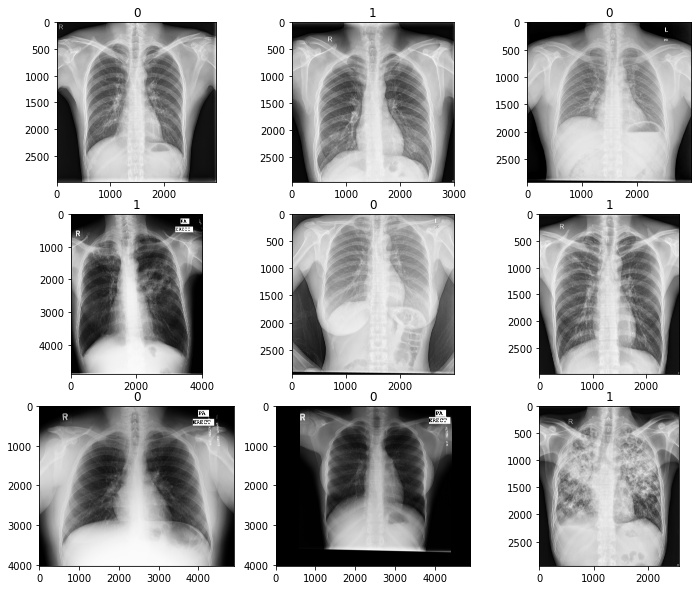

In [37]:
#Training images
nrows = 3
rands = np.random.randint(len(train_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(os.path.join(PATHS['images'], train.loc[rands[i], 'filename']))
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

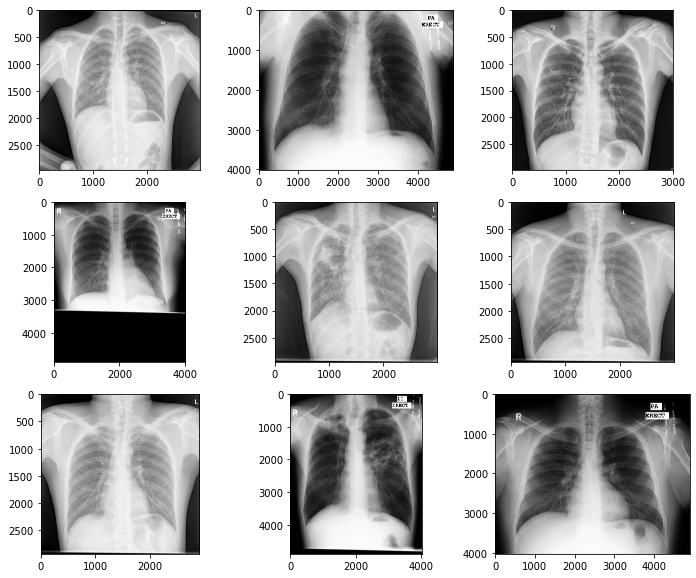

In [38]:
#Test images
nrows = 3
rands = np.random.randint(len(test_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(os.path.join(PATHS['test_images']+'test', sub.loc[rands[i], 'image']))
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
plt.show()

# Training 

In [42]:
epochs = 15                # training epochs
device = 'cuda' if torch.cuda.is_available() else 'cpu'            # in order to run model on GPU
size = (300, 300)          # image size
arch = 'resnet50'       # pre-trained model architecture used
layer = 'fc'
fc_size = 2208             # Fully connected layer size
bs = 32                    # training Batch size
eval_bs = 16               # Evaluation Batch size
lr = 1e-4               # learning rate


Avg_acc = 0        # variable for getting the average of auc results after training
Avg_auc = 0        # variable for getting the average of acc results after training
best_fold = 0          # variable for getting the best fold number after training    
fold_auc = 0  # initialize fold auc to 0


######################################  TRAINING PART ###################################
# run training loop over our 10 folds

for fold in range(n_folds):
  print('*'*10)
  print(f'Fold {fold+1}/{n_folds}')
  print('*'*10)
  _score, best_acc = run_fold(fold=fold,
                    train=train,
                    device = device, 
                    bs=bs, 
                    eval_bs=eval_bs, 
                    arch=arch, 
                    layer=layer,
                    epochs=epochs,
                    size=size, 
                    lr=lr)
    
  Avg_auc += _score
  Avg_acc += best_acc


  if _score > fold_auc:
      fold_auc = _score
      best_fold = fold

######################################  TRAINING PART ###################################

# Predict

In [ ]:
# 1
MODELS = load_models(arch=arch, layer=layer, fc_size=fc_size, input_size = size)

# 2
predictions_labels, predictions_proba = predict(sub, size=size, MODELS=MODELS, bs=2)

# Create submission file

In [ ]:
sample_sub_df = pd.read_csv(os.path.join(PATHS['raw'], 'SampleSubmission.csv'))
sample_sub_df.head()

,ID,LABEL
0,GTWSHFYQ,0
1,QTFSSMGD,0
2,TBLBHSYT,0
3,ZKETEOFG,0
4,GKTPBGZP,0


In [ ]:
submission = pd.DataFrame()
submission['ID'] = [fn.split('.')[0] for fn in sub['image'].tolist()]

for i, label in enumerate(["0", "1"]):
    submission[label] = 0

for i, label in enumerate(["0", "1"]):
    submission.loc[:,label] = predictions_proba[:,i]
    
submission['LABEL'] = predictions_labels



In [ ]:
#show predicted values
submission.head()

,ID,0,1,LABEL
0,IBJJCNUL,0.866122,0.131027,0
1,WTATMMWS,0.492218,0.497154,1
2,ACPRJNQA,0.992186,0.007856,0
3,OQZHUNYA,0.986873,0.013248,0
4,FUYAZRWU,0.936999,0.062495,0


# Save file

In [ ]:
# Format dataframe to match Zindi sample submission file 
# and use experiment variables to keep relevant infos on it
subs = submission[['ID', '1']]
subs.columns = ['ID', 'LABEL']
subs.to_csv(os.path.join(base_dir, f'torch_tb_{arch}_folds_{n_folds}_epochs_{epochs}_size_{size}_LR_{lr}.csv'), index=False)



In [ ]:
! nvidia-smi

Wed Nov 18 03:14:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   80C    P0    46W /  70W |  12427MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------